We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)



# Reinforcement Learning (DQN) Tutorial
**Author**: [Adam Paszke](https://github.com/apaszke)
            [Mark Towers](https://github.com/pseudo-rnd-thoughts)


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v1 task from [Gymnasium](https://gymnasium.farama.org)_.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging environments at
[Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)_.

.. figure:: /_static/img/cartpole.gif
   :alt: CartPole

   CartPole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
We take these 4 inputs without any scaling and pass them through a
small fully-connected network with 2 outputs, one for each action.
The network is trained to predict the expected value for each action,
given the input state. The action with the highest expected value is
then chosen.


**Packages**


First, let's import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/)_ for the environment,
installed by using `pip`. This is a fork of the original OpenAI
Gym project and maintained by the same team since Gym v0.19.
If you are running this in Google Colab, run:


In [3]:
%matplotlib inline
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 73.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495184 sha256=057866816a1f64c3ad04444d501e3e938049fca49e5d7ee2e7b6ca208dc11bf4
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
^C
ERROR: Operation cancelled by user


In [9]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# SEED = 42

# # # Set random seed for NumPy
# np.random.seed(SEED)

# # # Set random seed for Python's built-in random module
# random.seed(SEED)


# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)
#     torch.backends.cudnn.deterministic = True
# #     # torch.backends.cudnn.benchmark = False



# env = gym.make(
#     "LunarLander-v2",
#     continuous = False,
#     gravity = -10.0,
#     enable_wind = False,
#     wind_power = 15.0,
#     turbulence_power = 1.5,
# )

# env.seed(SEED)

# env = gym.make('LunarLander-v2')

# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0', max_episode_steps=1000)
# env = gym.make('MountainCar-v0', max_episode_steps=500)
# env = gym.make("Acrobot-v1")

# env = gym.make("BipedalWalker-v3")
# env.action_space.seed(SEED)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classes:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

## DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes
rewards from the uncertain far future less important for our agent
than the ones in the near future that it can be fairly confident
about. It also encourages agents to collect reward closer in time
than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a feed forward  neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [11]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,128)
#         self.layer3 = nn.Linear(128,128)
        # self.layer4 = nn.Linear(128,128)
        self.layer4 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
        # x = F.relu(self.layer4(x))
        return self.layer4(x)

    def forward_correlation(self, x):
        x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
        # x = F.relu(self.layer4(x))
        return F.relu(self.layer2(x))

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the duration of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [12]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
# LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(n_observations, n_actions)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
faster_lr = 1e-3
slower_lr = 1e-3

###  CHANGE THISSSSSS
# slower_lr = 1e-3

# # Create separate parameter groups for layers 1-3 and layer 4
# slower_params = list(map(id, policy_net.layer1.parameters() + policy_net.layer2.parameters() + policy_net.layer3.parameters()))
# faster_params = list(map(id, policy_net.layer4.parameters()))

# # Create an optimizer with different learning rates for each parameter group
# optimizer = optim.AdamW(
#     [
#         {"params": [p for p in policy_net.parameters() if id(p) in faster_params], "lr": faster_lr},
#         {"params": [p for p in policy_net.parameters() if id(p) in slower_params], "lr": slower_lr},
#     ]
# )

params = [
    {'params': policy_net.layer1.parameters(), 'lr':slower_lr },
    {'params': policy_net.layer2.parameters(), 'lr': slower_lr},
#     {'params': policy_net.layer3.parameters(), 'lr': slower_lr},  # Last two layers
    {'params': policy_net.layer4.parameters(), 'lr': faster_lr},  # Last two layers
]

# Define your optimizer with different learning rates for each parameter group
optimizer = optim.Adam(params)



memory = ReplayMemory(50000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

2 3


### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by
the hyperparameter ``TAU``, which was previously defined.




In [6]:
# # temp_env  = gym.make('MountainCar-v0', max_episode_steps=500)
# temp_env = gym.make(
#     "LunarLander-v2",
#     continuous = False,
#     gravity = -10.0,
#     enable_wind = False,
#     wind_power = 15.0,
#     turbulence_power = 1.5,
# )
# def call_correlation_coeff():

#     state_vector = []
#     state, info = temp_env.reset()
#     state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
#     for t in count():
# #         if (np.remainder(t,100) == 0):

#         state_vector.append(policy_net.forward_correlation(state))
#         state = temp_env.observation_space.sample()
#         state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
#         if t >100:
#           break
#         # action = select_action(state)
#         # observation, reward, terminated, truncated, _ = temp_env.step(action.item())
#         # reward = torch.tensor([reward], device=device)

#         # done = terminated or truncated

#         # if done:
#         #     break
#         # else:
#         #     next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

#         # state = next_state

#     # state_vector = state_vector
#     stacked_tensor = torch.stack(state_vector)
#     reshaped_tensor = stacked_tensor.reshape(len(state_vector), -1)
#     correlation_matrix = torch.corrcoef(reshaped_tensor)
# #     print(correlation_matrix)
#     correlation_values = torch.masked_select(correlation_matrix, torch.triu(torch.ones_like(correlation_matrix), diagonal=1).bool())
#     # Average correlation across all pairs of tensor vectors
#     average_correlation = correlation_values.mean()
#     return average_correlation

K means and then sampling from those clusters


In [7]:

from sklearn.cluster import KMeans

# Create your Gym environment
# env = gym.make('YourEnvNameHere')

# Define the number of clusters (bins)
# k = 25
k=10
# k=50
# k=5

# Initialize an empty list to store the clustered states
clustered_states = []

# Reset the environment to get the initial state
state = env.reset()

# Initialize an empty list to store all states
all_states = []

# Collect a bunch of states from the environment
for _ in range(2000):  # You can adjust the number of samples as needed
    action = env.action_space.sample()
    # print(env.step(action))
    state, _, done,_,_= env.step(action)
    all_states.append(state)
    if done:
        state = env.reset()

# Convert the list of states into a numpy array
all_states = np.array(all_states)

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(all_states)
# Get the indices of states belonging to each cluster
cluster_indices = [np.where(kmeans.labels_ == i)[0] for i in range(k)]

# Sample a random state from each cluster
# print(cluster_indices)
# Print the sampled states from each cluster
# for i, sampled_state in enumerate(clustered_states):
#     print(f"Sampled state from cluster {i+1}: {sampled_state}")


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
def call_correlation_coeff_kmeans():

    state_vector = []
    for indices in cluster_indices:
    # Randomly select an index from the cluster
      sampled_index = np.random.choice(indices)
      # Get the corresponding state
      sampled_state = torch.tensor(all_states[sampled_index]).to(device)
      # Add the sampled state to the list
      state_vector.append(policy_net.forward_correlation(sampled_state))
      # state_vector.append(sampled_state)

    stacked_tensor = torch.stack(state_vector)
    reshaped_tensor = stacked_tensor.reshape(len(state_vector), -1)
    correlation_matrix = torch.corrcoef(reshaped_tensor)
#     print(correlation_matrix)
    correlation_values = torch.masked_select(correlation_matrix, torch.triu(torch.ones_like(correlation_matrix), diagonal=1).bool())
    # print(state_vector)
    # Average correlation across all pairs of tensor vectors
    average_correlation = correlation_values.mean()
    return average_correlation

In [9]:
call_correlation_coeff_kmeans()

tensor(0.9647, grad_fn=<MeanBackward0>)

In [10]:
import pickle
from torch.autograd import Variable
global corr_mult 
corr_mult =1
def optimize_model():
    if not hasattr(optimize_model, "count"):
        optimize_model.count = 0

    optimize_model.count += 1



    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # print("works until here")
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # print(state_batch[0])
    # print("policy"  + str(state_action_values[0]))


    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # print(reward_batch)
    # print("expected" + str(expected_state_action_values[0]))

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # print(loss)
    # if (optimize_model.count % 60 == 0): print(loss)
    # print(loss)

    # loss = Variable(loss, requires_grad = True)

    # with torch.no_grad():
    correlation_coeff = call_correlation_coeff_kmeans()
    # print(correlation_coeff)

    # Define regularization strength

    # For LUNAAAA
    lambda_corr = 0.1 # You can adjust this parameter as needed

    #for ACROOOO
    lambda_corr = 0.1
#     print(loss, correlation_coeff)

     #for Mountyainnnnn
    
#     corr_mult = 1
    lambda_corr = 1 - corr_mult
#     lambda_corr = 0.1
#     print(loss, correlation_coeff)
#     print(lambda_corr)
    # Add correlation coefficient regularization term to the loss
    loss += (min(0.05,lambda_corr) * correlation_coeff) #(lambda_corr* correlation_coeff)
#     loss += (min(0.05,lambda_corr) * (correlation_coeff)**2)
    loss_for_plot.append(loss.detach().numpy())
#     print(loss.detach().numpy())
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:
from itertools import count
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500
rew_for_plot = []
loss_for_plot = []
avg_loss=[]
for i_episode in range(num_episodes):
    # if((i_episode + 1) % 25 == 0):
    #     with open("train_dqn_" + str(i_episode + 1) + ".pkl", 'wb') as file:
    # # Serialize and write the object to the file
    #         pickle.dump(policy_net, file)

    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    tot_rew = 0

    for t in count():
        # print(t)
        action = select_action(state)
        # print(action)
        observation, reward, done, info, _= env.step(action.item())
        # print(rew)

        #For mountain car HEREEEE
        # state_0 = state[0][0].item()
        # reward = 50 if observation[0]>=0.5 else abs(observation[0] - state_0)*100
        # print(reward)
        
        tot_rew += reward
        
        reward = torch.tensor([reward], device=device)

        # try gamma later
        
        # print(tot_rew)

        

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        done = done or info
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
#         print(policy_net.forward(state))
        state = next_state

        # Perform one step of the optimization (on the policy network)

        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(tot_rew)
            corr_mult *= 0.999
#             if i_episode > 1:# and np.remainder(i_episode,100) == 0:
            print(i_episode,call_correlation_coeff_kmeans(),tot_rew,1- corr_mult,np.mean(episode_durations[-100:]))
            avg_loss.append(np.mean(loss_for_plot))
            loss_for_plot=[]
            rew_for_plot.append(np.mean(episode_durations[-10:]))

            # plot_durations()
            break
    ## lunar lander
    if np.mean(episode_durations[-10:]) > 200:
        break


    #Mountain car
#     if np.mean(episode_durations[-10:]) > -200:
#         break
    

# print('Complete')
# plot_durations(show_result=True)


0 tensor(0.9989, grad_fn=<MeanBackward0>) -1000.0 0.0010000000000000009 -1000.0
1 tensor(0.9928, grad_fn=<MeanBackward0>) -1000.0 0.001998999999999973 -1000.0
2 tensor(0.9945, grad_fn=<MeanBackward0>) -1000.0 0.002997000999999999 -1000.0
3 tensor(0.9952, grad_fn=<MeanBackward0>) -1000.0 0.003994003998999962 -1000.0
4 tensor(0.9947, grad_fn=<MeanBackward0>) -1000.0 0.004990009995000988 -1000.0
5 tensor(0.9958, grad_fn=<MeanBackward0>) -1000.0 0.0059850199850060015 -1000.0
6 tensor(0.9956, grad_fn=<MeanBackward0>) -790.0 0.006979034965020947 -970.0
7 tensor(0.9960, grad_fn=<MeanBackward0>) -866.0 0.007972055930055899 -957.0
8 tensor(0.9960, grad_fn=<MeanBackward0>) -437.0 0.008964083874125839 -899.2222222222222
9 tensor(0.9959, grad_fn=<MeanBackward0>) -782.0 0.009955119790251765 -887.5
10 tensor(0.9963, grad_fn=<MeanBackward0>) -768.0 0.010945164670461471 -876.6363636363636
11 tensor(0.9965, grad_fn=<MeanBackward0>) -1000.0 0.011934219505790988 -886.9166666666666
12 tensor(0.9959, grad_

In [12]:
print(rew_for_plot)

[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -970.0, -957.0, -899.2222222222222, -887.5, -864.3, -864.3, -823.2, -823.2, -798.4, -797.1, -818.1, -831.5, -831.2, -851.9, -823.2, -808.8, -786.0, -786.0, -767.5, -721.2, -670.7, -620.5, -650.8, -577.0, -556.8, -499.8, -483.7, -406.7, -374.9, -350.3, -322.5, -300.7, -255.1, -254.8, -287.5, -285.6, -365.6, -442.6, -517.7, -557.6, -605.2, -614.5, -610.7, -608.2, -642.2, -638.9, -638.9, -638.9, -555.6, -587.9, -618.6, -611.6, -601.8, -610.0, -531.0, -523.3, -433.0, -364.6, -363.5, -275.8, -184.9, -164.0, -180.4, -159.7, -154.0, -153.7, -154.2, -138.4, -137.8, -140.8, -147.0, -153.2, -137.7, -142.8, -172.2, -172.4, -178.1, -178.1, -179.8, -180.3, -181.6, -175.8, -176.2, -176.6, -152.9, -152.7, -152.3, -151.7, -150.2, -149.4, -147.9, -149.4, -148.7, -148.4, -145.4, -141.2, -140.3, -137.0, -136.1, -138.2, -134.7, -135.3, -131.9, -127.8, -126.4, -133.1, -130.3, -129.4, -126.4, -118.6, -121.6, -121.0, -120.7, -118.4, -118.2, -110.2, -109.

In [13]:
print(avg_loss)

[0.0027779795, 0.0010066346, 0.0020494533, 0.003063758, 0.0041830298, 0.005039707, 0.006128069, 0.01169889, 0.014692703, 0.025190368, 0.022759503, 0.026500378, 0.03023768, 0.036712196, 0.034695275, 0.03856084, 0.043270882, 0.03728353, 0.034379497, 0.043071363, 0.04333932, 0.043008536, 0.04934709, 0.06172949, 0.04931148, 0.05436766, 0.057511732, 0.052086756, 0.052693654, 0.047239736, 0.048183676, 0.04920909, 0.053977847, 0.06329537, 0.06024953, 0.07292775, 0.06769695, 0.08145785, 0.088086605, 0.09871094, 0.098241575, 0.10434754, 0.11537968, 0.13876504, 0.15960681, 0.17471941, 0.18927634, 0.20459595, 0.23341753, 0.21801852, 0.23479587, 0.2486075, 0.25558844, 0.25970203, 0.29085192, 0.29163212, 0.30955553, 0.34402362, 0.34318608, 0.34187037, 0.37950465, 0.34957817, 0.36916304, 0.38746142, 0.40645584, 0.36753172, 0.33950004, 0.40925226, 0.40430275, 0.39647043, 0.4250605, 0.45471132, 0.44151583, 0.43157393, 0.3950335, 0.5284769, 0.4808763, 0.46813706, 0.48652083, 0.50747293, 0.48746508, 0.5

In [18]:
# rew_plot_van = [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -999.1, -978.3, -978.3, -971.1, -939.4, -939.4, -889.5, -889.5, -889.5, -889.5, -890.4, -911.2, -911.2, -918.4, -941.9, -941.9, -991.8, -991.8, -970.4, -961.5, -950.7, -908.5, -892.8, -867.1, -814.3, -755.6, -705.1, -696.4, -678.9, -642.2, -649.4, -640.7, -610.2, -580.8, -575.8, -568.5, -591.7, -526.6, -490.9, -463.8, -388.2, -364.9, -336.7, -322.7, -327.1, -335.6, -290.5, -295.8, -336.3, -335.0, -338.4, -329.3, -328.8, -324.3, -304.4, -289.3, -279.0, -274.3, -241.8, -240.2, -248.2, -257.0, -289.8, -280.2, -286.4, -277.0, -281.3, -279.3, -255.9, -249.9, -234.8, -235.2, -194.1, -193.1, -184.4, -185.1, -180.9, -174.1, -180.4, -171.9, -171.9, -161.6, -179.4, -191.7, -190.9, -188.2, -186.6, -178.2, -187.0, -192.8, -198.1, -198.2, -213.0, -215.1, -215.8, -223.5, -224.3, -231.3, -215.5, -224.9, -235.0, -234.3, -242.9, -235.0, -282.6, -268.9, -268.2, -267.1, -272.6, -269.6, -268.9, -269.9, -221.5, -222.7, -174.6, -173.4, -173.2, -172.9, -173.9, -179.8, -163.1, -163.2, -168.2, -158.9, -158.8, -165.0, -164.8, -161.3, -155.7, -142.9, -143.3, -142.5, -143.6, -143.8, -144.6, -144.8, -146.3, -150.5, -155.2, -155.5, -150.1, -150.7, -148.9, -148.3, -147.8, -148.2, -143.2, -143.4, -139.6, -140.0, -145.3, -144.5, -146.0, -147.8, -148.9, -149.1, -149.1, -144.9, -146.0, -142.1, -138.8, -132.1, -132.8, -129.3, -127.9, -123.7, -123.9, -128.3, -127.9, -127.6, -127.1, -130.4, -125.8, -124.8, -121.0, -121.1, -119.6, -114.5, -114.5, -119.4, -119.6, -119.7, -119.2, -119.5, -119.6, -119.7, -120.2, -120.7, -120.7, -115.6, -115.4, -115.2, -116.8, -116.8, -117.1, -116.8, -119.8, -120.7, -120.6, -120.8, -121.3, -123.0, -122.4, -123.5, -123.1, -123.6, -121.5, -120.8, -120.8, -123.7, -123.3, -121.1, -120.6, -119.5, -120.2, -119.4, -124.8, -124.0, -123.6, -120.2, -120.2, -120.3, -119.9, -119.7, -118.4, -117.1, -111.1, -111.2, -111.4, -111.0, -110.0, -110.1, -109.9, -109.6, -110.4, -111.3, -110.9, -110.5, -110.1, -110.3, -110.4, -110.0, -109.9, -110.0, -109.3, -109.2, -108.6, -108.6, -108.6, -108.6, -108.5, -108.4, -108.5, -108.2, -108.1, -108.2, -106.4, -106.5, -106.6, -105.5, -105.7, -105.5, -104.1, -104.1, -103.9, -103.8, -106.4, -104.0, -111.2, -111.7, -111.4, -111.5, -112.5, -112.2, -112.5, -118.6, -118.1, -120.5, -112.7, -111.5, -111.5, -120.9, -121.1, -121.2, -119.3, -113.7, -113.1, -111.6, -110.0, -111.8, -112.4, -109.4, -109.2, -109.6, -111.7, -119.4, -118.5, -119.9, -121.0, -121.4, -121.7, -117.0, -118.4, -119.3, -128.9, -121.8, -127.9, -126.4, -131.2, -131.3, -132.0, -135.0, -133.8, -135.7, -128.9, -137.3, -137.4, -138.8, -138.2, -143.0, -146.1, -141.4, -144.7, -142.6, -140.3, -133.6, -130.7, -135.3, -131.8, -128.7, -129.8, -130.3, -124.9, -129.2, -128.6, -125.8, -126.8, -125.9, -127.7, -129.0, -126.8, -130.2, -133.0, -128.9, -128.6, -127.3, -129.2, -125.6, -122.0, -118.3, -118.3, -114.0, -113.5, -112.8, -111.8, -113.3, -108.4, -108.1, -110.0, -110.6, -106.7, -107.4, -106.9, -104.9, -104.0, -102.3, -106.4, -105.4, -105.3, -105.1, -105.4, -111.3, -111.6, -113.5, -120.7, -122.3, -119.0, -118.2, -118.8, -118.7, -119.0, -113.8, -114.6, -114.9, -110.7, -110.9, -110.6, -113.1, -111.2, -110.7, -110.7, -110.9, -110.6, -108.0, -106.6, -112.2, -112.1, -112.8, -114.8, -112.7, -113.4, -110.5, -111.3, -114.3, -115.2, -110.1, -113.9, -113.2, -110.7, -111.2, -111.3, -113.8, -113.2, -113.3, -113.5, -113.1, -109.3, -109.8, -112.1, -114.2, -113.5, -113.2, -113.0, -112.4, -112.0, -112.2, -112.7, -110.4, -110.5, -109.0, -108.9, -108.7, -108.7, -108.8, -108.7, -108.2, -107.6, -109.2, -108.9, -110.2, -110.1, -108.8, -108.4, -107.9, -108.2]



# avg_loss_van = [1.571422303851612, 2.0668911843408564, 1.56605814321883, 1.6952522291035705, 1.4106137560553256, 1.307382238311949, 1.2954793228789296, 1.2990378075380549, 1.4069646984852655, 1.2882660402700528, 1.0242588582077448, 0.8550277999540984, 0.7700507100251475, 0.6362207254825922, 0.6444384036130089, 0.6184897708174943, 0.7419294143216961, 0.6356522099996609, 0.6041120172964213, 0.656619808830828, 0.5902222777556974, 0.5863662445976934, 0.5378752315458682, 0.5316375229293874, 0.5291011875565798, 0.4619997983487815, 0.5203331957823083, 0.5161693730576041, 0.5348661791725859, 0.557770148065136, 0.437697552098918, 0.5283044302606117, 0.5486156629692692, 0.5289226606684074, 0.5244127460355641, 0.4773907532127487, 0.5002097863276189, 0.5201505159355528, 0.48687262351607524, 0.4477142284316111, 0.4073499492255153, 0.5030911841094725, 0.49050883944625545, 0.47120988648295403, 0.4261533417387939, 0.47104902694369866, 0.4358666495015943, 0.5232941676918352, 0.5380694330627602, 0.4929513345069673, 0.449865537809895, 0.5669166836295845, 0.6130046539507169, 0.5049002219317873, 0.4821045385653805, 0.5531524542079609, 0.542111030634888, 0.5759425432749651, 0.5535026218115287, 0.5589486858091764, 0.5218684800493211, 0.583728303295957, 0.6168295878061876, 0.5995760228322756, 0.5441815256312736, 0.6376776817607004, 0.6820235358491242, 0.6614087208206548, 0.6940750328880366, 0.7314670909935282, 0.7206700266941047, 0.7547012672108967, 0.77629434105157, 0.81702199282702, 0.8206034288200321, 0.7978970532826912, 0.7651035368443119, 0.8037440221322928, 0.797536758468131, 0.7540538239527688, 0.754173697581875, 0.7329060946004193, 0.7675104180200186, 0.7151177881726667, 0.6957374842548582, 0.6979053291014801, 0.7024373392151837, 0.6887946814511571, 0.6495645327554386, 0.6460902987369951, 0.6649135724834129, 0.671758544710434, 0.6309619488161107, 0.5779426663421274, 0.5494834036458407, 0.5004193574539677, 0.5747477741683235, 0.5470469994840457, 0.5574985629012481, 0.513406949074381, 0.5472262747186201, 0.6022539870079266, 0.5452083112857622, 0.5858439882734204, 0.5627914709876795, 0.5730075748495708, 0.561304065536915, 0.5139675453574648, 0.5612853962876059, 0.4960898087346429, 0.47726805460311794, 0.5374896891709083, 0.5700471388883963, 0.4875567806507994, 0.558721419201253, 0.5647971780397185, 0.5895756287742341, 0.5422588378856701, 0.527010059637423, 0.516859249035388, 0.5021665800837929, 0.4779643179020339, 0.45577242062205625, 0.4528358381625152, 0.4497866543003423, 0.4868297343198615, 0.43996566782259205, 0.46561587739136323, 0.4234913387090058, 0.42110071575166275, 0.40647537642894516, 0.4327756418962383, 0.37324057316345316, 0.431689052348246, 0.41201235706366496, 0.3787415885986302, 0.38612756316661095, 0.4082960078356786, 0.44736132044303695, 0.3990924907238438, 0.41379966841844223, 0.34196857413490006, 0.3862647107601122, 0.37712845325734223, 0.3548135600128927, 0.3812018103577902, 0.35898781272958913, 0.450642739255097, 0.39699553557068434, 0.39046126907109274, 0.3868246556336898, 0.3636029918664031, 0.42208274067881535, 0.37722975937438913, 0.3544501032812192, 0.4067535113580099, 0.376969583333046, 0.38687453640941627, 0.309659869254748, 0.36841702673345644, 0.41582394363871056, 0.4385759967870624, 0.400447912452789, 0.38335601811474496, 0.4261993253089666, 0.3870109013989028, 0.4223526987094746, 0.4066602376282979, 0.397811037353677, 0.4049718683149547, 0.3950871084774395, 0.5203330560224281, 0.39991157531919413, 0.4740206098741186, 0.405920204651461, 0.4051129301373584, 0.38083945843467504, 0.4080141480752431, 0.38681860027306925, 0.4815808734723086, 0.4070203204192869, 0.4352436138379724, 0.3726997250085114, 0.4105111144976718, 0.39780968500650793, 0.46616636727410415, 0.4067108872675874, 0.41577743807073625, 0.45471484668199585, 0.4293018308895093, 0.44763604153911346, 0.3915714905584619, 0.4844320599396735, 0.44270329606481607, 0.4032168724242753, 0.4246840094795253, 0.4315933073971716, 0.44543503089277864, 0.46348908516853893, 0.4326561713403329, 0.4199806442975313, 0.4683198520150089, 0.409223176492997, 0.4144049730274688, 0.4400116388476051, 0.44284390704911614, 0.40963253590973103, 0.4341693901716102, 0.42980765394956655, 0.41079361252367486, 0.42413580291272707, 0.4657867847389385, 0.4087127847908291, 0.4048025584019864, 0.469219469317388, 0.4632816853290725, 0.37554494475641953, 0.4686308101626668, 0.4394788946364862, 0.41948248438177577, 0.47154534703039747, 0.4886038403358241, 0.44990160013522956, 0.40715594205139616, 0.4502282317617816, 0.4548154534561709, 0.5000347681161506, 0.45934709177290556, 0.4274964878778653, 0.44467027292513356, 0.5842520416679791, 0.4706504549874987, 0.46943344523552205, 0.5215975318586825, 0.4554908203826788, 0.5021782254823182, 0.44544863206430874, 0.5238045938869823, 0.5184600385578157, 0.5430207954105019, 0.4166648603057246, 0.5053935344124291, 0.48640072656993305, 0.4560489467191298, 0.6458341778401324, 0.6039233710566326, 0.5173841220650627, 0.4934575292473956, 0.4689521525593275, 0.5329199471385486, 0.5093951407505729, 0.5165012189758086, 0.5342872382906848, 0.48253619740109593, 0.5358954843817243, 0.5298950836716221, 0.5231445377031496, 0.49795939216264773, 0.53120324950145, 0.4313604756873426, 0.5149346341940645, 0.45238629085673826, 0.5050495914191061, 0.5727387425250537, 0.5264594789374234, 0.5063122251938016, 0.529245865160849, 0.533358405870129, 0.47085936855097166, 0.45450962121847244, 0.4126579404516798, 0.5012953437857712, 0.4598111720900262, 0.4839277550558381, 0.46133484557289245, 0.4719263970764978, 0.5691429975591854, 0.47362280429669146, 0.4464869130127869, 0.45260147943776935, 0.43620731561735115, 0.507464255389641, 0.44405731264537285, 0.42853814060527945, 0.44558224349931647, 0.4533486592822199, 0.46030415966172733, 0.3883893315215664, 0.5098796196552315, 0.4606146826171981, 0.44931803988287344, 0.5413446892758075, 0.4687480303967306, 0.4921814851548791, 0.5777768849171419, 0.4364215384610432, 0.47250352336791457, 0.4857784192917546, 0.39175993511790985, 0.5467880930630105, 0.4828981545334774, 0.4470385676260792, 0.5185025200354538, 0.457972529862634, 0.5145729511147792, 0.4834242428105013, 0.5248825172472186, 0.5037733034115788, 0.4616707908870608, 0.4845801049110812, 0.4472136680288817, 0.4612773549734093, 0.5409298942223432, 0.4998830569436734, 0.4482268433698362, 0.43981367485748496, 0.5102319588996471, 0.4700847382469986, 0.48767080899613313, 0.477574590562799, 0.46339827537125966, 0.4455956702263332, 0.479711553571671, 0.42098251661307673, 0.4509874146555204, 0.5097687341071983, 0.5184215172067864, 0.47681919153300145, 0.483679106368073, 0.4218617397073861, 0.4728084467082567, 0.44726813781842234, 0.45045753874212296, 0.43171892548100876, 0.5654799149116322, 0.5330139615232785, 0.44792759670769366, 0.5153208032563975, 0.41790461411107793, 0.48705085019201577, 0.4510781147106251, 0.3818982671137263, 0.41968952596809633, 0.5644446520758243, 0.5054887907142954, 0.47972184225768316, 0.559294530955135, 0.48901359407814143, 0.47565593688841035, 0.5247851117354686, 0.5425395409393825, 0.5044615944538231, 0.49300848108950523, 0.49839283989643324, 0.421167849306889, 0.4289135910434434, 0.4905040219947002, 0.4607743877460446, 0.517177315269333, 0.51856176926364, 0.526625412536932, 0.5034174112113222, 0.5757453645424001, 0.5222917666388557, 0.5525667373624544, 0.46321599825171167, 0.5145461665031817, 0.4927289821322127, 0.5135282829211687, 0.5730027191206886, 0.49281541427687936, 0.4862650868696867, 0.5490446918373746, 0.614010396473496, 0.5840045396779487, 0.4503074602434561, 0.5603260682305912, 0.5821505228616777, 0.42153262808255515, 0.5338290639997102, 0.5906410851508995, 0.6140724166778598, 0.6187544650947381, 0.535994606576252, 0.5246352913654843, 0.6516639524574178, 0.5852282276560049, 0.5905753498554739, 0.6207653536923389, 0.5395693268407262, 0.5219000412560585, 0.5248453768039629, 0.5867643411174054, 0.47649072349750327, 0.6640045550591829, 0.5577397020923864, 0.5610118528340253, 0.6399070412060928, 0.5876375213876994, 0.6025526038089619, 0.6211884258574301, 0.5283177902938662, 0.5504164854011935, 0.6325534306677513, 0.6432461104409828, 0.6396231055443026, 0.5418579636641552, 0.5863071325338379, 0.48239981562323025, 0.6309180737842485, 0.5813868131328414, 0.5755873902607477, 0.5644008950684866, 0.7356142864756715, 0.6153445019045852, 0.594482014465375, 0.5691637895108487, 0.6859038587353239, 0.6288001009981093, 0.6096548088194148, 0.6456133042210245, 0.7442214071933269, 0.6652935710071216, 0.5861947478109372, 0.5887549704939203, 0.6435562308187569, 0.6296689571293173, 0.6073751064932342, 0.7694970883424231, 0.6586245842130191, 0.712809149935479, 0.5792645223187436, 0.64843376719193, 0.7575711207452839, 0.6201853523931151, 0.7302554683205953, 0.6367341076131847, 0.6259089049713501, 0.6653420977893909, 0.6932289389776037, 0.7323280282311999, 0.6162202785977972, 0.7019768715841012, 0.7200841292948771, 0.7143973784108286, 0.7468322602017334, 0.6282995925936543, 0.70424572042515, 0.6791730092041928, 0.5846740568141529, 0.6421537263323465, 0.6571888258835554, 0.6430493514335899, 0.8303019813711328, 0.757589111307497, 0.5673355754533123, 0.6652917112304457, 0.6590331616435586, 0.6827473063929657, 0.8864007243572535, 0.6997107131135473, 0.7272629228624276, 0.6558016402019347, 0.8517889373461126, 0.6629596853564645, 0.7847948043256517, 0.6890388279572659, 0.597193593634728, 0.7065996567874298, 0.6328962738349683, 0.7092024767741942, 0.793370770547945, 0.8072550590114891, 0.7620656207061639, 0.6695031636525213, 0.6340217446388404, 0.737806551206138, 0.6468201836632337, 0.6660529311152904, 0.6198496840956541, 0.6599388605500015, 0.7129612057413314, 0.704623288651908, 0.8355196889386063, 0.6737252281721133, 0.6815078029120897, 0.7228682262598963, 0.7836032674475599, 0.7102131913798965, 0.6665619753596981, 0.8217970722964598, 0.6369145134585154, 0.6068005528521511, 0.6746917503665913, 0.6679349563019807, 0.6804591868121019, 0.7394136208954076, 0.6801078536892776, 0.6934848610246352, 0.7048561422548456]

# # rew_for_plot = [-332.1897519725735, -225.75788238868017, -198.84933540301995, -167.07164316549344, -145.1098117518503, -126.90897630383074, -110.20642134024857, -91.76987743204367, -84.02348091285747, -83.4839658716455, -52.08010849207464, -52.834815114708206, -45.93097132536171, -38.6728629407767, -35.74654241387933, -54.81772181052357, -59.12107481125537, -46.77782134244647, -46.21103315770606, -42.470536321903865, -16.451022727756076, 20.068805166544006, 48.85627651634269, 37.47777791003258, 35.91518369673016, 56.68362316807507, 58.49231643366088, 39.494988015821704, 39.22178424636697, 67.01726126242804, 38.624700725077865, 10.194745343943449, -8.5526518954723, -0.7185281862034337, -0.7275696029767609, -4.755386466461038, -5.221811424856639, 12.98019172529047, 12.75995907128738, -11.105513369547863, -7.81245334155214, -9.56985288681442, -15.241553955617622, 6.270790659026098, 8.82402726572516, 9.384040370681621, 12.844505534484474, -2.5491199555946453, -1.3803400271516992, 1.663761923333761, -3.529380227153827, -0.7917444378501791, 27.659486948737474, -9.46431087063877, 1.0030552879761985, 23.031105817953584, 47.04277059231505, 67.41643314639659, 89.13270068218581, 106.62705173617451, 114.60532704421318, 138.34284329877295, 107.4125556831062, 137.43410842523446, 134.14160117106016, 130.76945281250406, 132.3246335026692, 131.16793508989215, 118.94798639340517, 98.26827886225904, 116.86032507970928, 114.05943183092629, 121.50066632552867, 107.08009828135684, 106.10779972160815, 90.0153460282914, 63.6085439704763, 45.48166663931842, 36.026533058782874, 33.43510623782328, 10.972240604260879, -0.7210349809026099, -1.1964532850183542, 4.802419610657609, 25.821056448222368, 31.256560487674893, 50.04205216001653, 50.62011868720537, 70.25766006398015, 85.73942783970217, 113.79708867619047, 128.55370653390338, 143.74502755955544, 162.64851815725527, 160.26463103785125, 173.86276560244696, 170.50729837990497, 196.22930778566024, 200.3633736304026, 185.93106446978692, 176.65834998826253, 179.83343825623035, 178.01097631867648, 173.01656920327736, 166.67951895640036, 164.3270782080522, 162.99713035239304, 153.1730290443683, 142.9391491486226, 158.49512511421452, 152.20033644032048, 130.61340534849813, 129.3214288343751, 130.47240905111764, 132.33356613914492, 142.49848643062506, 130.11993155928678, 111.1329982333468, 123.15901382456391, 121.78752588326913, 127.4651240074879, 126.69385094184551, 135.85762979975996, 122.1219920788933, 103.1220925746461, 88.40571598740937, 100.45875854390204, 94.20702105864419, 81.20484648144738, 75.43734137250438, 69.80806276673395, 84.48080781024979, 78.01292963554764, 90.03369353312482, 88.24398149162326, 103.12127799387706, 102.01329373075254, 121.92733203889313, 135.9832417703613, 143.20610980592147, 153.9701213086405, 163.74338218421263, 170.546853587209, 161.359327197892, 178.9695058313219, 181.0364381189669, 194.69534394740546, 193.67423412020378, 187.4191975780832, 190.7220633763668, 196.74877615279956, 185.82684335290585, 179.69906468879375, 202.07169233736317, 202.37895196426112, 189.37012331673242, 180.0977432828666, 196.0600372573935, 204.03308116065836, 200.34407248016973, 198.21744858179306, 200.4727200727334, 208.26931790043818, 202.61624528313723, 212.7565803640079, 200.19263450306232, 187.0456441452856, 159.6742950007411, 158.90410401983718, 148.81563434809118, 139.77414584504598, 149.90549529251015, 120.26628850049528, 113.23787400391329, 102.6591057437139, 129.34722896623464, 129.87790465619526, 132.0164766827915, 133.1662651556017, 157.29888337205767, 107.54531483688952, 81.03974419304176, 113.64463248916358, 100.1930461995134, 111.30461038951543, 101.14971369772675, 127.46230392734674, 143.83869684048554, 142.3012371314465, 140.6748531865485, 198.11247359595353, 221.67123650510476, 207.48954311692023, 229.11661101345334, 227.49869655859234, 212.4613592808912, 186.1087436539939, 184.40449843696155, 151.84041348230386, 103.74070773476626, 81.26068453518948, 81.934274137676, 83.28091782892508, 58.32787892105779, 47.87846497974362, 62.00913973222242, 58.98347692727604, 46.753430810582344, 71.1214503154498, 110.66989827787468, 123.62414384918168, 102.07994574171616, 117.19532204796333, 131.06360112306885, 146.179306110379, 144.5445352887288, 162.1269371962482, 174.64704317432137, 159.73841462262743, 147.89648780361952, 156.76172804459935, 170.41706466292675, 146.5751804893093, 157.77178477638026, 128.65916459124838, 140.65635289848564, 149.04614009294755, 132.65537684342354, 134.0695235740655, 130.8419943218134, 106.78234760245293, 117.14851303829307, 137.8749108921836, 111.45496205700663, 129.01373036856594, 128.19003083194937, 125.55504959443219, 148.76823701783883, 171.74586259732104, 185.13911739808026, 203.81171073035267, 181.89848305273375, 181.42893363858573, 210.16649928791207, 219.79866686934082, 221.87710170586269, 221.6684713209363, 227.63371531599128, 226.76047671282646, 236.29588704843027, 241.12221888961085, 261.72746604517334, 259.3873131350976, 262.06333878174365, 261.08853974324774, 262.1408775659414, 255.06876845302753, 251.66327767753228, 249.53547930415283, 252.1224859115304, 255.95390017483086, 246.82641566377188, 247.91568987441605, 235.6895317686563, 228.69608391413504, 216.8150506005246, 214.92644539889005, 219.33921034204172, 212.32879848443804, 214.84438096383002, 205.7968091883353, 206.17239817324383, 209.44716833674033, 220.14018826506117, 230.2002356375755, 238.19653548989058, 249.5221113613605, 244.7790245701166, 240.26817338630204, 234.15698024894112, 242.98179269099973, 241.97450468048586, 239.5007801135852, 221.84765111594, 217.1114977822167, 219.90323216404127, 220.12002790824636, 221.28124571121322, 225.91583081916747, 230.44372459534566, 232.13785508261873, 240.43387449565876, 241.9072825516329, 260.33103317325754, 262.751766266853, 251.36817306132633, 252.8877577217614, 250.40471878219267, 236.23522445443396, 237.20002467995013, 233.69631811804948, 213.72169111703653, 209.6581482424032, 206.30621556110924, 206.58162810642602, 217.08763026839884, 218.2411859165399, 222.06734887461167, 246.31060695832122, 245.27292547612328, 236.4217384837138, 257.0950192458319, 262.35968541280164, 265.00429932852546, 256.45276618386845, 257.39532149447416, 231.32251169428497, 204.646888042976, 208.19003243293588, 206.793167235456, 215.4439011309863, 218.24985187411806, 189.72230571232257, 160.4236897439953, 170.25807961913011, 160.4542612898923, 175.0196531903709, 175.37338694357933, 169.38870492193388, 168.36792026351003, 122.48719006901176, 112.15543063059992, 138.16060191350275, 168.4924698803427, 140.7992494237935, 149.5659641551511, 158.68125299059096, 159.69971192868974, 136.5729986952702, 128.71900671057244, 178.57736343940195, 188.9096482261171, 165.89181277083645, 165.02232473030554, 188.70388796170215, 178.201174731439, 169.05141025389497, 180.05715863181848, 193.19204345681237, 174.820004011682, 163.49509025972307, 163.05945625272668, 162.02004485788945, 132.28466270475215, 134.15967129522068, 147.2227286240965, 145.07248110174447, 159.5919617414642, 162.23313128115464, 191.74545867181263, 201.26562483849926, 200.25654134287277, 213.68656701548397, 231.23911387701204, 229.4710958282849, 207.292711520906, 217.19894060982716, 203.89871395325125, 211.49658789044466, 211.30590633280613, 210.53845325302663, 212.67758500091094, 227.1295785462167, 235.70689627248893, 207.4632072710373, 204.6411975803411, 208.95879313015604, 222.28120261410317, 224.88006380539113, 197.57581231069216, 187.13172290893064, 184.246765707813, 181.94683230265562, 164.560778206511, 194.0584193908576, 217.59869551231986, 205.3811457572734, 177.09326605032896, 175.88915003792522, 204.45123245531803, 207.2134202895573, 209.94150368204595, 212.38530558179212, 223.88417681368793, 201.58955926782653, 188.0558957667866, 200.53106337767423, 229.22403128447687, 220.15060309757632, 215.47455971681885, 215.4629300495416, 212.51875605295794, 181.09101511526438, 187.260591798714, 210.61743668477465, 223.4221947694645, 209.46188633510943, 181.4085317465251, 191.4100651189864, 194.3049480442747, 167.84874314070856, 156.8876280553926, 189.23901714843333, 176.43025373236065, 164.71110602947417, 155.673954112535, 156.8301964108636, 158.8606611006315, 147.43870259679005, 136.7710454102491, 152.4544424601107, 165.22864344248563, 164.7970693949348, 167.87956215806003, 156.4737178267111, 167.80983295610827, 169.59586641647988, 193.70968390584025, 205.24732347809012, 190.03617166519868, 212.23041747822063, 209.47563723857826, 184.76806596982513, 177.47776482393658, 200.61007497458175, 177.33612365602818, 161.83998042762727, 163.35475486768664, 155.26808764401954, 179.8172819934317, 178.24275639200064, 153.17648093521822, 174.77975327239523, 196.8933816734396, 187.8921301934816, 181.84449792756848, 208.98977824032872, 197.92631339825124, 207.48378109781635, 208.82626864964922, 182.26289736833542, 202.96134861418977, 200.39310924375167, 188.85314064634915, 197.94806869269937, 225.50170146937316, 199.3574163077114, 186.40186562155088, 164.07822974193067, 139.22986703857038, 167.4234420534718, 147.92596149683473, 149.12399660730537, 155.57451687931382, 142.403340245519, 60.48950043494087, 83.04607884614265, 26.306660643980514, 11.142995138130496, 31.88366233342058, -4.198944261349998, 12.020870516473595, 5.073809753951681, -16.16871727523256, -13.87396494210084, 38.53209454625939, 18.970134056175546, 85.71744715515776, 92.50247530532073, 83.31162757894126, 116.11249125888966, 124.32245457999963, 110.5646538766387, 123.11025521544484, 125.4764060459355, 143.58949414230568, 141.88195356349925, 142.88785869971207, 169.7244970637889, 182.5303911718069, 159.16219238644342, 165.4637262392983, 163.79128016603377, 164.84053793287558, 172.4535903819937, 184.9136752240962, 185.9977960125048, 194.77712096917293, 195.98168696653443, 168.62347804622934]

rew_plot_van = [-20.06877353888521, -161.03643809789605, -140.6912573725308, -126.02078578763002, -119.72203542944483, -106.62192697104483, -139.38309471492883, -151.9617976543442, -114.38096717870798, -111.73557105887744, -115.1059676658227, -89.61499606855733, -87.87645074935556, -82.18809153125427, -79.8115576214583, -79.84328976689693, -47.61393303717546, -2.5773764206977576, -23.334958061946914, 6.209223628700377, 8.581406328736186, 13.913908112206428, 20.33571555082022, 42.59063151110588, 76.47483549608837, 86.14244449658682, 106.53843293298937, 93.2392832807561, 96.17528175885836, 87.90152175079365, 50.908928887158666, 31.456782123147423, 52.744333720902794, 55.94749233617779, 33.57288087929011, 36.9938418136986, 40.39458094507849, 52.18991622224455, 64.3404633955746, 50.372862052581624, 94.74152013868365, 136.17727273108034, 131.12456865993167, 131.67773651963813, 122.38395994818067, 113.58497147505325, 96.54432359761049, 75.45551731630795, 85.80393938015484, 81.71475228177641, 71.75549091636078, 75.57559873398876, 56.068652467271974, 30.853059839043635, 34.595685710988135, 60.768364030551695, 79.93642064993648, 89.63585941521123, 65.95396409495474, 97.17421674445862, 102.74444007675238, 73.24832765915237, 102.57592257504916, 117.86391673877775, 118.61581227577919, 99.42616431498251, 100.3699872741112, 115.51966173006443, 121.21789252748306, 115.1445848661468, 119.91855514043736, 129.3813435380748, 109.56242598969754, 105.11409319174595, 115.65631407921009, 128.23443209891886, 104.44883748456562, 74.93176611574776, 75.87368518792087, 73.03381708186568, 67.95499194834063, 64.47761446019895, 85.62084520792992, 90.06521386439803, 94.02350572739002, 86.73825486902035, 86.25810837886505, 113.26793221991211, 130.0017040217683, 138.26061814120087, 148.27823874989028, 170.4142714705903, 156.90325885349228, 154.74089656561034, 160.9549498204526, 173.24463697835745, 197.15960626120668, 204.4917809848646, 181.00454811467415, 184.50253215492242, 193.68266407985368, 195.60304440740197, 209.55035081796785, 229.21054586735613, 232.99941325480262, 233.5928810614424, 232.8034590756512, 231.8217821471365, 259.3711683013065, 259.28972732406476, 267.5672311683439, 250.1518525323109, 251.5466957973374, 249.7137028778743, 237.19365084150064, 238.144243197443, 241.6107704511992, 227.60943319577723, 201.09944983698202, 169.51368982211602, 166.55323138581716, 172.64131490402698, 158.79086540387362, 133.42345313565335, 123.48580450793494, 120.17350853953653, 90.05933739527298, 85.23293531113123, 110.75379677939902, 137.6740226867791, 136.17523040155277, 131.9186773380044, 143.7287199322131, 166.32176651733135, 186.1746216341184, 181.0859432858274, 204.38146046543375, 224.8197266673069, 225.30616049822993, 228.1539373691275, 230.92150124236287, 243.87551013737848, 239.1837581846468, 236.79120437137385, 242.7940098979997, 252.4954622362298, 257.47892291230636, 231.3709206136345, 228.67205957102797, 217.35714464255665, 218.14204381773757, 218.6947744197993, 227.81274787614294, 204.90181879759774, 198.61827162675485, 124.95799129196764, 122.72798485139715, 64.02028924848031, 37.48621999832177, 46.60500042744037, 47.31885387707121, 47.837864519032586, 45.52428545590965, 45.82388206388997, 53.15267444859107, 127.01997584857426, 129.48921471618104, 211.36205626327455, 241.56261023365815, 232.14404043586592, 223.336634288202, 225.31326775911174, 216.16979910037622, 222.51553387542293, 222.62336472251735, 220.41886665097277, 195.90178005412676, 200.31232587051497, 200.9575171192206, 186.79776015459476, 195.32446990049644, 193.53220482807603, 201.53281357650158, 198.78246300767594, 173.13349618365618, 149.43430022454478, 160.21651747004927, 132.28208012560006, 103.80175605724196, 105.95529654390853, 104.43383027958696, 102.23216382152444, 101.24903693590707, 113.86623556391062, 134.51800234028423, 158.5179121952275, 140.53750653965648, 166.7908040435999, 193.24899338621853, 204.1752276319428, 204.04419997402408, 198.7285473223763, 176.13095712639753, 182.743241583966, 184.2756947874732, 174.03599904333183, 206.50318302378304, 202.64099866436737, 180.59548710091582, 195.60340685967776, 195.30272637200562, 205.5911287189621, 227.87676584123136, 230.32637444695766, 235.49072059055948, 246.2860397953802, 244.3174979975285, 244.00542897827623, 268.6420402681347, 269.70885588076123, 273.6186628175451, 271.1805555796241, 271.69528525307055, 268.5599163656578, 268.36501593039225, 270.6771813392618, 250.7943273067025, 255.65581745599192, 237.3003076054143, 237.66693709010855, 236.85247398627735, 238.55888193350884, 236.94265978068674, 245.23052831220986, 242.28938816133805, 239.3498136876811, 260.80326315743594, 256.28665405394946, 269.00911377263685, 268.3302146350021, 268.40681579863093, 268.78309234746655, 249.3200077447259, 247.97179171551426, 248.5337725274315, 250.2599741373453, 250.83701923920881, 252.6623186608921, 257.0952951590918, 257.7397237580837, 254.6639299390602, 252.7355148804505, 264.63528643222037, 258.16504091830944, 259.4967845678756, 258.58838718007235, 259.6784084308189, 258.3486148423068, 242.82156946589288, 241.52286927452715, 242.03151435102882, 241.24373196925634, 250.7878079824971, 251.27199960890047, 250.30345367224413, 248.3496007751873, 248.8439369489152, 252.43728785508839, 270.67173004459994, 267.5447909668084, 264.3025998857678, 265.74795954006225, 267.88327106879626, 269.60019424500604, 265.0818144741451, 254.82943416610124, 231.3293168696492, 207.42264724354033, 201.8023694974965, 179.9794700935875, 185.11495648798626, 190.35963527119716, 191.9035928552442, 189.49007912299498, 189.97917481117747, 204.6861675249907, 226.43395775066793, 227.40270101931665, 230.70423665458011, 230.97450038161324, 229.9118289206504, 226.38638677374792, 191.63372301890593, 195.6771807945678, 200.98203982608683, 198.5274850351064, 195.9769419869281, 214.65354079215336, 189.18599561436523, 181.77093150895433, 180.80873084263177, 147.74607413861784, 180.08619796703255, 176.8442617236304, 145.3793543265616, 145.98820654049567, 145.52827574840342, 148.0056487467736, 170.95439273617885, 198.35963674908166, 201.9909508680218, 237.1075876414895, 237.08339387333126, 239.3845697085015, 270.7387787220999, 271.2893194945673, 252.38279012952256, 255.01792219455038, 254.3502316886057, 256.9512828420927, 254.69875685658502, 253.36055195938857, 252.5249308710175, 252.12551497909553, 249.50237877657247, 233.90535766317424, 257.39649786228154, 224.77528377795483, 226.61370778270384, 227.50083160267167, 204.10027574267548, 199.32999568726802, 196.7708215994342, 194.93468754150473, 189.42062962345886, 203.9321555738415, 202.97277182069894, 208.14952318892034, 187.22917781230512, 188.3932295855118, 212.6122872846097, 180.41616450718197, 156.17972979671487, 160.17045930326066, 167.4660288121078, 167.3443936526791, 163.64407826152777, 190.29693442102038, 214.50284726021283, 214.16874259342612, 214.78830796701703, 252.27866410902752, 278.6469062758865, 276.727725894274, 250.3740680124502, 205.090364838536, 184.18234639652414, 157.41367682854252, 157.13746820942967, 143.87055717054218, 141.23556645788523, 113.98880808724252, 117.29002696784683, 120.00980401015477, 144.75114121185143, 168.25028385622306, 192.5286938104868, 218.6624795527328, 218.39503093550957, 205.23107487899497, 209.88668807005516, 238.3507863951958, 213.36451622084058, 213.71450960776195, 191.97536018258978, 189.4989244136749, 190.90120567189888, 192.537497972065, 166.4493277876548, 191.1818831822779, 190.23294829696658, 175.75509810136435, 200.19426789511712, 167.44224555506716, 164.35491714348646, 167.36393154508366, 139.09668597665365, 112.87019645224716, 112.0281242678772, 114.10417475318152, 90.31479955053874, 77.6683317544619, 75.31737010665196, 83.55587832495222, 80.9687295858814, 81.09195164403435, 81.8532461166389, 108.51507147219505, 135.02519992941734, 108.81202070824195, 130.153135913394, 129.03521139608907, 103.98822562461665, 101.40679260736542, 108.18082348857983, 131.31718162099816, 132.90443225405664, 105.49402489796435, 83.4665465514971, 82.65468715759052, 56.74954156544737, 54.246341445011545, 54.63406801813507, 53.687256047680464, 71.08925441101054, 73.12153735743402, 75.25371464202144, 90.31769528996959, 115.0747468309917, 115.22917604528591, 116.96864997106582, 146.78804941758364, 175.1046699970565, 175.22663802789913, 153.7557255077472, 150.66516274191366, 151.41777748017475, 136.03609770337, 104.42598904259744, 106.57849235343205, 99.83685557986439, 72.51670271707471, 46.646178740731244, 45.66272374932653, 46.86917812846038, 25.146273418278398, 50.27072342557038, 49.22886614607641, 56.350780538092735, 82.50577989688949, 91.80896551417743, 91.39831510895681, 116.17228755005881, 142.36263658532192, 169.92913519101677, 193.61398048562407, 189.34779273798927, 214.84404857693727, 234.00961339268684, 231.01475064806792, 231.62122408802492, 258.3273881855257, 257.63265831714165, 236.41570175076058, 203.38623962167168, 199.09801284726024, 200.26249964981565, 177.2447586912286, 175.85991421702454, 150.31923509765807, 147.14916374122024, 118.67733741206575, 117.40825194224583, 141.13855211698154, 170.58108172042785, 145.83575410735298, 121.86261543459368, 120.91287138230359, 123.38113313525727, 149.5069921677479, 173.99550070004324, 171.7557600353694, 142.54627755566327, 140.2038680325923, 115.67856367386682, 143.25776025074106, 143.59155153679322, 167.11705242241047, 169.93849357610765, 143.2422351461098, 106.0356554601386, 135.09168609906337, 163.49343426719184, 139.2363900339587, 137.85756167900647, 137.52796936860628, 162.3926488390543, 139.97900529141265, 138.34699320383524, 161.6368286603659, 173.78521548114642, 147.9996834984328, 124.4318172679339, 150.87969062547182, 176.73928873730284, 174.36746552155952, 172.5011492970025, 197.5991757395188, 172.59850673263583, 177.4463217230989]


rew_for_plot = [-332.1897519725735, -225.75788238868017, -198.84933540301995, -167.07164316549344, -145.1098117518503, -126.90897630383074, -110.20642134024857, -91.76987743204367, -84.02348091285747, -83.4839658716455, -52.08010849207464, -52.834815114708206, -45.93097132536171, -38.6728629407767, -35.74654241387933, -54.81772181052357, -59.12107481125537, -46.77782134244647, -46.21103315770606, -42.470536321903865, -16.451022727756076, 20.068805166544006, 48.85627651634269, 37.47777791003258, 35.91518369673016, 56.68362316807507, 58.49231643366088, 39.494988015821704, 39.22178424636697, 67.01726126242804, 38.624700725077865, 10.194745343943449, -8.5526518954723, -0.7185281862034337, -0.7275696029767609, -4.755386466461038, -5.221811424856639, 12.98019172529047, 12.75995907128738, -11.105513369547863, -7.81245334155214, -9.56985288681442, -15.241553955617622, 6.270790659026098, 8.82402726572516, 9.384040370681621, 12.844505534484474, -2.5491199555946453, -1.3803400271516992, 1.663761923333761, -3.529380227153827, -0.7917444378501791, 27.659486948737474, -9.46431087063877, 1.0030552879761985, 23.031105817953584, 47.04277059231505, 67.41643314639659, 89.13270068218581, 106.62705173617451, 114.60532704421318, 138.34284329877295, 107.4125556831062, 137.43410842523446, 134.14160117106016, 130.76945281250406, 132.3246335026692, 131.16793508989215, 118.94798639340517, 98.26827886225904, 116.86032507970928, 114.05943183092629, 121.50066632552867, 107.08009828135684, 106.10779972160815, 90.0153460282914, 63.6085439704763, 45.48166663931842, 36.026533058782874, 33.43510623782328, 10.972240604260879, -0.7210349809026099, -1.1964532850183542, 4.802419610657609, 25.821056448222368, 31.256560487674893, 50.04205216001653, 50.62011868720537, 70.25766006398015, 85.73942783970217, 113.79708867619047, 128.55370653390338, 143.74502755955544, 162.64851815725527, 160.26463103785125, 173.86276560244696, 170.50729837990497, 196.22930778566024, 200.3633736304026, 185.93106446978692, 176.65834998826253, 179.83343825623035, 178.01097631867648, 173.01656920327736, 166.67951895640036, 164.3270782080522, 162.99713035239304, 153.1730290443683, 142.9391491486226, 158.49512511421452, 152.20033644032048, 130.61340534849813, 129.3214288343751, 130.47240905111764, 132.33356613914492, 142.49848643062506, 130.11993155928678, 111.1329982333468, 123.15901382456391, 121.78752588326913, 127.4651240074879, 126.69385094184551, 135.85762979975996, 122.1219920788933, 103.1220925746461, 88.40571598740937, 100.45875854390204, 94.20702105864419, 81.20484648144738, 75.43734137250438, 69.80806276673395, 84.48080781024979, 78.01292963554764, 90.03369353312482, 88.24398149162326, 103.12127799387706, 102.01329373075254, 121.92733203889313, 135.9832417703613, 143.20610980592147, 153.9701213086405, 163.74338218421263, 170.546853587209, 161.359327197892, 178.9695058313219, 181.0364381189669, 194.69534394740546, 193.67423412020378, 187.4191975780832, 190.7220633763668, 196.74877615279956, 185.82684335290585, 179.69906468879375, 202.07169233736317, 202.37895196426112, 189.37012331673242, 180.0977432828666, 196.0600372573935, 204.03308116065836, 200.34407248016973, 198.21744858179306, 200.4727200727334, 208.26931790043818, 202.61624528313723, 212.7565803640079, 200.19263450306232, 187.0456441452856, 159.6742950007411, 158.90410401983718, 148.81563434809118, 139.77414584504598, 149.90549529251015, 120.26628850049528, 113.23787400391329, 102.6591057437139, 129.34722896623464, 129.87790465619526, 132.0164766827915, 133.1662651556017, 157.29888337205767, 107.54531483688952, 81.03974419304176, 113.64463248916358, 100.1930461995134, 111.30461038951543, 101.14971369772675, 127.46230392734674, 143.83869684048554, 142.3012371314465, 140.6748531865485, 198.11247359595353, 221.67123650510476, 207.48954311692023, 229.11661101345334, 227.49869655859234, 212.4613592808912, 186.1087436539939, 184.40449843696155, 151.84041348230386, 103.74070773476626, 81.26068453518948, 81.934274137676, 83.28091782892508, 58.32787892105779, 47.87846497974362, 62.00913973222242, 58.98347692727604, 46.753430810582344, 71.1214503154498, 110.66989827787468, 123.62414384918168, 102.07994574171616, 117.19532204796333, 131.06360112306885, 146.179306110379, 144.5445352887288, 162.1269371962482, 174.64704317432137, 159.73841462262743, 147.89648780361952, 156.76172804459935, 170.41706466292675, 146.5751804893093, 157.77178477638026, 128.65916459124838, 140.65635289848564, 149.04614009294755, 132.65537684342354, 134.0695235740655, 130.8419943218134, 106.78234760245293, 117.14851303829307, 137.8749108921836, 111.45496205700663, 129.01373036856594, 128.19003083194937, 125.55504959443219, 148.76823701783883, 171.74586259732104, 185.13911739808026, 203.81171073035267, 181.89848305273375, 181.42893363858573, 210.16649928791207, 219.79866686934082, 221.87710170586269, 221.6684713209363, 227.63371531599128, 226.76047671282646, 236.29588704843027, 241.12221888961085, 261.72746604517334, 259.3873131350976, 262.06333878174365, 261.08853974324774, 262.1408775659414, 255.06876845302753, 251.66327767753228, 249.53547930415283, 252.1224859115304, 255.95390017483086, 246.82641566377188, 247.91568987441605, 235.6895317686563, 228.69608391413504, 216.8150506005246, 214.92644539889005, 219.33921034204172, 212.32879848443804, 214.84438096383002, 205.7968091883353, 206.17239817324383, 209.44716833674033, 220.14018826506117, 230.2002356375755, 238.19653548989058, 249.5221113613605, 244.7790245701166, 240.26817338630204, 234.15698024894112, 242.98179269099973, 241.97450468048586, 239.5007801135852, 221.84765111594, 217.1114977822167, 219.90323216404127, 220.12002790824636, 221.28124571121322, 225.91583081916747, 230.44372459534566, 232.13785508261873, 240.43387449565876, 241.9072825516329, 260.33103317325754, 262.751766266853, 251.36817306132633, 252.8877577217614, 250.40471878219267, 236.23522445443396, 237.20002467995013, 233.69631811804948, 213.72169111703653, 209.6581482424032, 206.30621556110924, 206.58162810642602, 217.08763026839884, 218.2411859165399, 222.06734887461167, 246.31060695832122, 245.27292547612328, 236.4217384837138, 257.0950192458319, 262.35968541280164, 265.00429932852546, 256.45276618386845, 257.39532149447416, 231.32251169428497, 204.646888042976, 208.19003243293588, 206.793167235456, 215.4439011309863, 218.24985187411806, 189.72230571232257, 160.4236897439953, 170.25807961913011, 160.4542612898923, 175.0196531903709, 175.37338694357933, 169.38870492193388, 168.36792026351003, 122.48719006901176, 112.15543063059992, 138.16060191350275, 168.4924698803427, 140.7992494237935, 149.5659641551511, 158.68125299059096, 159.69971192868974, 136.5729986952702, 128.71900671057244, 178.57736343940195, 188.9096482261171, 165.89181277083645, 165.02232473030554, 188.70388796170215, 178.201174731439, 169.05141025389497, 180.05715863181848, 193.19204345681237, 174.820004011682, 163.49509025972307, 163.05945625272668, 162.02004485788945, 132.28466270475215, 134.15967129522068, 147.2227286240965, 145.07248110174447, 159.5919617414642, 162.23313128115464, 191.74545867181263, 201.26562483849926, 200.25654134287277, 213.68656701548397, 231.23911387701204, 229.4710958282849, 207.292711520906, 217.19894060982716, 203.89871395325125, 211.49658789044466, 211.30590633280613, 210.53845325302663, 212.67758500091094, 227.1295785462167, 235.70689627248893, 207.4632072710373, 204.6411975803411, 208.95879313015604, 222.28120261410317, 224.88006380539113, 197.57581231069216, 187.13172290893064, 184.246765707813, 181.94683230265562, 164.560778206511, 194.0584193908576, 217.59869551231986, 205.3811457572734, 177.09326605032896, 175.88915003792522, 204.45123245531803, 207.2134202895573, 209.94150368204595, 212.38530558179212, 223.88417681368793, 201.58955926782653, 188.0558957667866, 200.53106337767423, 229.22403128447687, 220.15060309757632, 215.47455971681885, 215.4629300495416, 212.51875605295794, 181.09101511526438, 187.260591798714, 210.61743668477465, 223.4221947694645, 209.46188633510943, 181.4085317465251, 191.4100651189864, 194.3049480442747, 167.84874314070856, 156.8876280553926, 189.23901714843333, 176.43025373236065, 164.71110602947417, 155.673954112535, 156.8301964108636, 158.8606611006315, 147.43870259679005, 136.7710454102491, 152.4544424601107, 165.22864344248563, 164.7970693949348, 167.87956215806003, 156.4737178267111, 167.80983295610827, 169.59586641647988, 193.70968390584025, 205.24732347809012, 190.03617166519868, 212.23041747822063, 209.47563723857826, 184.76806596982513, 177.47776482393658, 200.61007497458175, 177.33612365602818, 161.83998042762727, 163.35475486768664, 155.26808764401954, 179.8172819934317, 178.24275639200064, 153.17648093521822, 174.77975327239523, 196.8933816734396, 187.8921301934816, 181.84449792756848, 208.98977824032872, 197.92631339825124, 207.48378109781635, 208.82626864964922, 182.26289736833542, 202.96134861418977, 200.39310924375167, 188.85314064634915, 197.94806869269937, 225.50170146937316, 199.3574163077114, 186.40186562155088, 164.07822974193067, 139.22986703857038, 167.4234420534718, 147.92596149683473, 149.12399660730537, 155.57451687931382, 142.403340245519, 60.48950043494087, 83.04607884614265, 26.306660643980514, 11.142995138130496, 31.88366233342058, -4.198944261349998, 12.020870516473595, 5.073809753951681, -16.16871727523256, -13.87396494210084, 38.53209454625939, 18.970134056175546, 85.71744715515776, 92.50247530532073, 83.31162757894126, 116.11249125888966, 124.32245457999963, 110.5646538766387, 123.11025521544484, 125.4764060459355, 143.58949414230568, 141.88195356349925, 142.88785869971207, 169.7244970637889, 182.5303911718069, 159.16219238644342, 165.4637262392983, 163.79128016603377, 164.84053793287558, 172.4535903819937, 184.9136752240962, 185.9977960125048, 194.77712096917293, 195.98168696653443, 168.62347804622934]


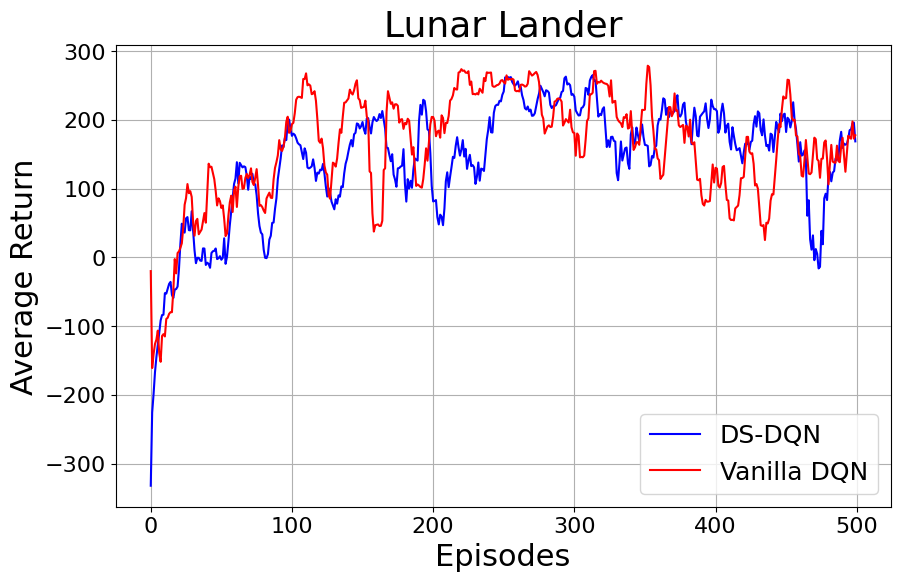

In [19]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(500),rew_for_plot, label="DS-DQN", color='blue')
plt.plot(range(500),rew_plot_van, label="Vanilla DQN", color='red')

# Adding labels and title
plt.xlabel('Episodes',fontsize = 22)
plt.ylabel('Average Return', fontsize = 22)
plt.title('Lunar Lander', fontsize = 26)

# Adding a legend to distinguish between the two plots
plt.legend(fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Displaying the plot
plt.grid(True)
plt.show()

In [16]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
# plt.plot(range(len(rew_for_plot)),rew_for_plot)
# plt.xlabel("Episodes")
# plt.ylabel("Average Return")
# # plt.ioff()
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(500),avg_loss, label="DS-DQN", color='blue')
# plt.plot(range(500),avg_loss_van, label="Vanilla DQN", color='red')

# # Adding labels and title
# plt.xlabel('Episodes')
# plt.ylabel('Average Loss')
# # plt.title('Comparison of Rew Plot and Rew Plot Van')

# # Adding a legend to distinguish between the two plots
# plt.legend()

# # Displaying the plot
# plt.grid(True)
# plt.show()

In [ ]:
# plt.plot(range(len(avg_loss)),avg_loss)
# # plt.ioff()
# plt.xlabel("Episodes")
# plt.ylabel("Average Loss")
# plt.show()

In [ ]:
# import statistics

# # Example list of numbers
# data = [1882, 1673, 1823]




# # Calculate variance
# variance = statistics.stdev(data)

# print(f"Variance: {variance}")


# Noisy evaluation

In [ ]:
# num_episodes = 100
# episode_durations = []
# for i_episode in range(num_episodes):
#     # if((i_episode + 1) % 25 == 0):
#     #     with open("train_dqn_" + str(i_episode + 1) + ".pkl", 'wb') as file:
#     # # Serialize and write the object to the file
#     #         pickle.dump(policy_net, file)

#     # Initialize the environment and get its state
#     state, info = env.reset()
#     state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
#     tot_rew = 0

#     for t in count():
#         # print(t)
#         state += torch.randn(state.size())*1
#         action = select_action(state)
#         # print(action)
#         observation, reward, done, info, _= env.step(action.item())
#         # print(rew)

#         #For mountain car HEREEEE
#         # state_0 = state[0][0].item()
#         # reward = 50 if observation[0]>=0.5 else abs(observation[0] - state_0)*100
#         # print(reward)

#         tot_rew += reward
        
#         reward = torch.tensor([reward], device=device)

#         # try gamma later
        
#         # print(tot_rew)

        

#         if done:
#             next_state = None
#         else:
#             next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

#         done = done or info
        
#         # Store the transition in memory
# #         memory.push(state, action, next_state, reward)

#         # Move to the next state
#         state = next_state

#         # Perform one step of the optimization (on the policy network)

# #         optimize_model()

#         # Soft update of the target network's weights
#         # θ′ ← τ θ + (1 −τ )θ′
# #         target_net_state_dict = target_net.state_dict()
# #         policy_net_state_dict = policy_net.state_dict()
# #         for key in policy_net_state_dict:
# #             target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
# #         target_net.load_state_dict(target_net_state_dict)

#         if done:
#             episode_durations.append(tot_rew)
# #             if i_episode > 1:# and np.remainder(i_episode,100) == 0:
#             print(i_episode,call_correlation_coeff_kmeans(),tot_rew)
#             # plot_durations()
#             break
# print(np.mean(episode_durations))

# # print('Complete')
# # plot_durations(show_result=True)
# # plt.ioff()
# # plt.show()

In [ ]:
def phi_wrapper(state, marker = 0):
    if(marker == 1): state = state[0]
    # print("hello" + str(state.shape))
    x = policy_net.forward_correlation(torch.tensor(state)).detach().numpy()
#     print("In phi wrapper. x shape", x.shape)
    return x #x/np.linalg.norm(x)

In [ ]:
class phi(nn.Module):

    def __init__(self, dqn):
        super(phi, self).__init__()
        self.layer1 = dqn.layer1
        self.layer2 = dqn.layer2
#         self.layer3 = dqn.layer3
        # self.layer4 = dqn.layer4

        # self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):         
        x = torch.tensor(x)
        x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))
        # x = F.relu(self.layer4(x))
        # x = F.relu(self.layer2(x))
        return F.relu(self.layer2(x))
    def forward_correlation(self, x):
        x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
        # x = F.relu(self.layer4(x))
        return F.relu(self.layer2(x))

In [ ]:
trained_phi = phi(policy_net)


In [ ]:
import pickle
with open("trained_phi.pkl", 'wb') as file:
    # Serialize and write the object to the file
    pickle.dump(trained_phi, file)

In [ ]:
import pickle
with open("/kaggle/working/trained_phi.pkl", 'rb') as file:
    # Serialize and write the object to the file
    policy_net = pickle.load(file)

In [15]:
num_features = 128  # Number of features (state dimensions)
num_actions = env.action_space.n  # Number of actions
weights = np.zeros((num_features, num_actions))


# new corrected code for script

In [16]:
# import gym
import numpy as np
# import copy

# Hyperparameters
# alpha = 0.00001  # Learning rate, 0.001 for mountaincar

#MC
alpha = 0.001
gamma = 0.99 # Discount factor
  # Epsilon-greedy exploration parameter
num_episodes = 5000# Number of episodes


# class CustomLunarLander(gym.envs.box2d.LunarLander):
#     def __init__(self):
#         super().__init__()
#         super().reset()
# #         self.helipad_x1 += np.random.uniform(-0.05, 0.05)  # Small adjustment
# #         self.helipad_x2 += np.random.uniform(-0.05, 0.05)  # Small adjustment
#         self.helipad_y+=np.random.uniform(-0.05, 0.05)  # Small adjustment

class CustomMountainCar(gym.envs.classic_control.MountainCarEnv):
    def __init__(self):
        super().__init__()
       

        # Modify the goal position slightly
        self.goal_position += np.random.uniform(-0.1, 0.1)



# Linear function approximation
def approximate_q(state, weights):
  
    return np.dot(phi_wrapper(state), weights)

curr_test_state = env.observation_space.sample()

def approximate_q_no_phi(state, weights):
  
    return np.dot((state), weights)

# print("hello", (approximate_q(curr_test_state), curr_policy_net(torch.tensor(curr_test_state)).detach().numpy()))

# Epsilon-greedy policy
def epsilon_greedy_policy(state,tot_steps,weights):
#     global steps_compl
#     print(steps_compl)
    epsilon = 0.1 + math.exp(-1. * tot_steps / 5000)

    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        q_values = approximate_q(state,weights)
        # print(q_values.shape)
        return np.argmax(q_values)  # Greedy action
    
def epsilon_greedy_policy_no_phi(state,tot_steps,weights):

    epsilon = 0.1 + math.exp(-1. * tot_steps / 5000)
 
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        q_values = approximate_q_no_phi(state,weights)
        # print(q_values.shape)
        return np.argmax(q_values)  # Greedy action
    
def epsilon_greedy_policy_mc(state,tot_steps,weights):

    epsilon = 0.2 + math.exp(-1. * tot_steps / 10000)
  
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        q_values = approximate_q(state,weights)
        # print(q_values.shape)
        return np.argmax(q_values)  # Greedy action
    
def epsilon_greedy_policy_mc_no_phi(state,tot_steps,weights):

    epsilon = 0.2 + math.exp(-1. * tot_steps / 10000)
  
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        q_values = approximate_q_no_phi(state,weights)
        # print(q_values.shape)
        return np.argmax(q_values)  # Greedy action


res=[]
for i in range(5):
#     env = gym.make('LunarLander-v2')
    env = gym.make('MountainCar-v0', max_episode_steps=1000)
#     duration_list = []
    num_features = 128  # Number of features (state dimensions)
    num_actions = env.action_space.n  # Number of actions
#     env = CustomLunarLander()
    env = CustomMountainCar()
#     weights = np.zeros((num_features, num_actions))
    weights = np.zeros((n_observations, num_actions))
    duration_list = []
    tot_steps = 0 
    for episode in range(num_episodes):

        state = env.reset()
        state = state[0]
        state_length = state.size
        # print(len(state))
        done = False
        steps = 0
        # episode_duration  = 0
        tot_rew = 0
        while not done:
    #         env.render()
            steps +=1
            tot_steps +=1
            #for lunar lnader without phi
#             action = epsilon_greedy_policy_no_phi(state,tot_steps,weights)
            #with phi
#             action = epsilon_greedy_policy(state,tot_steps,weights)
            #for mountain car
#             action = epsilon_greedy_policy_mc(state,tot_steps,weights)
#
            action = epsilon_greedy_policy_mc_no_phi(state,tot_steps,weights)
#             print(action)
            # print((env.step(action)))
            next_state, reward, done, _, _ = env.step(action)
    #         if done == False:
    #             reward += 1 
            tot_rew += reward

            
 
            if done:
                td_target = reward
            else:
#                 td_target = reward + gamma * np.max(approximate_q(next_state,weights))
                td_target = reward + gamma * np.max(approximate_q_no_phi(next_state,weights))
#             td_error = td_target - approximate_q(state,weights)[action]
            td_error = td_target - approximate_q_no_phi(state,weights)[action]
    #         print(td_target, td_error)
#             weights[:, action] += alpha * td_error * phi_wrapper(state)
            weights[:, action] += alpha * td_error * (state)
            # print(nn_weights)
            # print(alpha * td_error * phi_wrapper(state))

            state = next_state
            if steps >= 1000:
                break
        duration_list.append(tot_rew)
    #     plt.plot(duration_list)
    #     plt.pause(0.001)  # pause a bit so that plots are updated
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)
        if (episode%100==0):
            print(tot_rew)
#         if np.mean(duration_list[-10:]) > 200:
        if np.mean(episode_durations[-10:]) > -200 and episode >10:
#         if np.mean(duration_list[-10:]) > 200 :
            print("exit at", episode,duration_list[-10:])
            res.append(episode)
            break
        # if (episode + 1) % 100 == 0:
        #   print(f"Episode {episode + 1}/{num_episodes}")
        
    else:
        res.append(num_episodes)
        

print(res)
print(sum(res)/len(res))
stddev = statistics.stdev(res)

print(f"Std Dev: {stddev}")



-1000.0
-1000.0
-1000.0
-246.0
-214.0
-198.0
-197.0
-196.0
-276.0
-269.0
-273.0
-284.0
-352.0
-282.0
-342.0
-349.0
-348.0
-486.0
-395.0
-201.0
-394.0
-274.0
-695.0
-941.0
-199.0
-748.0
-871.0
-927.0
-1000.0
-568.0
-664.0
-562.0
-291.0
-1000.0
-273.0
-1000.0
-200.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-511.0
-510.0
-1000.0
-353.0
-1000.0
-1000.0
-791.0
-1000.0
-1000.0
-1000.0
-797.0
-174.0
-188.0
-296.0
-192.0
-255.0
-280.0
-277.0
-275.0
-322.0
-348.0
-352.0
-203.0
-370.0
-562.0
-279.0
-429.0
-338.0
-642.0
-270.0
-642.0
-596.0
-525.0
-824.0
-610.0
-497.0
-652.0
-991.0
-355.0
-519.0
-1000.0
-199.0
-276.0
-285.0
-354.0
-1000.0
-274.0
-1000.0
-376.0
-1000.0
-1000.0
-868.0
-1000.0
-1000.0
-653.0
-1000.0
-679.0
-1000.0
-1000.0
-1000.0
-829.0
-247.0
-199.0
-239.0
-288.0
-195.0
-273.0
-254.0
-339.0
-327.0
-281.0
-355.0
-360.0
-333.0
-357.0
-586.0
-434.0
-427.0
-489.0
-364.0
-499.0
-402.0
-618.0
-623.0
-356.0
-566.0
-845.0
-814.0
-729.0
-1000.0
-708.0
-464.0
-501.0
-1000.0
-796.0
-353.0
-656

In [14]:
import statistics
stddev = statistics.stdev(res)

print(f"Std Dev: {stddev}")


Std Dev: 0.0


In [ ]:
# # import gym
# import numpy as np
# import copy

# # Hyperparameters
# alpha = 0.00001  # Learning rate, 0.001 for mountaincar
# gamma = 0.99  # Discount factor
#   # Epsilon-greedy exploration parameter
# num_episodes = 10000# Number of episodes
# steps_compl = 0
# # Create the CartPole environment
# # env = gym.make('CartPole-v1', render_mode = 'none')
# # env = gym.make('LunarLander-v2', render_mode = 'none')
# # Initialize the weights for the linear function approximation

# # weights = np.random.rand(num_features, num_actions)
# # weights = copy.deepcopy(curr_nn_weights)

# # print("hskgd")


# # Linear function approximation
# def approximate_q(state, weights = weights):
#     # state = state[0]
#     # print(np.array(state).shape)
#     # print(phi_wrapper(state).shape)
#     # print(phi_wrapper(state).shape)
#     # print(weights.shape)
#     return np.dot(phi_wrapper(state), weights)

# curr_test_state = env.observation_space.sample()
# # print("hello", (approximate_q(curr_test_state), curr_policy_net(torch.tensor(curr_test_state)).detach().numpy()))

# # Epsilon-greedy policy
# def epsilon_greedy_policy(state):
#     global steps_compl
#     epsilon = 0.1 + math.exp(-1. * steps_compl / 5000)
#     # print(epsilon)
# #     epsilon = 0.3
# #     epsilon = 0.3
#     steps_compl += 1
#     if np.random.rand() < epsilon:
#         return env.action_space.sample()  # Random action
#     else:
#         q_values = approximate_q(state)
#         # print(q_values.shape)
#         return np.argmax(q_values)  # Greedy action

# # Q-learning algorithm with linear function approximation
# # env = gym.make(
# #     "LunarLander-v2",
# #     continuous = False,
# #     gravity = -10.0,
# #     enable_wind = False,
# #     wind_power = 15.0,
# #     turbulence_power = 1.5,
# #     render_mode = 'human'
# # )
# # for i in range(2):
# duration_list = []
# #     weights = np.zeros((num_features, num_actions))
# #     steps_compl = 0
# for episode in range(num_episodes):

#     state = env.reset()
#     state = state[0]
#     state_length = state.size
#     # print(len(state))
#     done = False
#     steps = 0
#     # episode_duration  = 0
#     tot_rew = 0
#     while not done:
# #         env.render()
#         steps +=1
#         # episode_duration += 1
# #         state += np.random.normal(0,0.1,state_length)
#         action = epsilon_greedy_policy(state)
#         # print(action)
#         # print(action)
#         # print((env.step(action)))
#         next_state, reward, done, _, _ = env.step(action)
# #         if done == False:
# #             reward = 0
#         tot_rew += reward

#     # print(state)
#     # Update Q-value using the Q-learning update rule
#     # print((next_state).shape)
#     # print(np.max(approximate_q((next_state))).shape)
#     # print(next_state)
#         if done:
#             td_target = reward
#         else:
#             td_target = reward + gamma * np.max(approximate_q((next_state)))
#         td_error = td_target - approximate_q((state))[action]
# #         print(td_target, td_error)
#         weights[:, action] += alpha * td_error * phi_wrapper(state)
#         # print(nn_weights)
#         # print(alpha * td_error * phi_wrapper(state))

#         state = next_state
#         if steps >= 1000:
#             break
#     duration_list.append(tot_rew)
# #     plt.plot(duration_list)
# #     plt.pause(0.001)  # pause a bit so that plots are updated
# #     display.display(plt.gcf())
# #     display.clear_output(wait=True)
#     if episode%100==0: print(tot_rew)
#     if np.mean(duration_list[-10:]) > 200:
#         print("exit at", episode)
#         break
#     # if (episode + 1) % 100 == 0:
# #     print(f"Episode {episode + 1}/{num_episodes}")

# # plt.pause(0.001)  # pause a bit so that plots are updated
# # display.display(plt.gcf())

# # plt.show()

# # Close the environment
# # env.close()

In [ ]:
# # import gym
# import numpy as np
# import copy

# # Hyperparameters
# alpha = 0.00001  # Learning rate, 0.001 for mountaincar
# gamma = 0.99  # Discount factor
#   # Epsilon-greedy exploration parameter
# num_episodes = 10000# Number of episodes
# steps_compl = 0
# # Create the CartPole environment
# # env = gym.make('CartPole-v1', render_mode = 'none')

# # Initialize the weights for the linear function approximation
# num_features = 32  # Number of features (state dimensions)
# num_actions = env.action_space.n  # Number of actions
# # weights = np.random.rand(num_features, num_actions)
# # weights = copy.deepcopy(curr_nn_weights)
# # weights = np.zeros((num_features, num_actions))

# # print("hskgd")


# # Linear function approximation
# def approximate_q(state, weights = weights):
#     # state = state[0]
#     # print(np.array(state).shape)
#     # print(phi_wrapper(state).shape)
#     # print(phi_wrapper(state).shape)
#     # print(weights.shape)
#     return np.dot(phi_wrapper(state), weights)

# curr_test_state = env.observation_space.sample()
# # print("hello", (approximate_q(curr_test_state), curr_policy_net(torch.tensor(curr_test_state)).detach().numpy()))

# # Epsilon-greedy policy
# def epsilon_greedy_policy(state):
#     global steps_compl
#     epsilon = 0.1 + math.exp(-1. * steps_compl / 5000)
# #     print(epsilon)
# #     epsilon = 0.3
#     epsilon = 0
#     steps_compl += 1
#     if np.random.rand() < epsilon:
#         return env.action_space.sample()  # Random action
#     else:
#         q_values = approximate_q(state)
#         # print(q_values.shape)
#         return np.argmax(q_values)  # Greedy action

# # Q-learning algorithm with linear function approximation
# # env = gym.make(
# #     "LunarLander-v2",
# #     continuous = False,
# #     gravity = -10.0,
# #     enable_wind = False,
# #     wind_power = 15.0,
# #     turbulence_power = 1.5,
# #     render_mode = 'human'
# # )
# duration_list = []
# for episode in range(num_episodes):
    
#     state = env.reset()
#     state = state[0]
#     state_length = state.size
#     # print(len(state))
#     done = False
#     steps = 0
#     # episode_duration  = 0
#     tot_rew = 0
#     while not done:
# #         env.render()
#         steps +=1
#         # episode_duration += 1
# #         state += np.random.normal(0,0.1,state_length)
#         action = epsilon_greedy_policy(state)
#         # print(action)
#         # print(action)
#         # print((env.step(action)))
#         next_state, reward, done, _, _ = env.step(action)
#         tot_rew += reward

#         # print(state)
#         # Update Q-value using the Q-learning update rule
#         # print((next_state).shape)
#         # print(np.max(approximate_q((next_state))).shape)
#         # print(next_state)
#         if done:
#             td_target = reward
#         else:
#             td_target = reward + gamma * np.max(approximate_q((next_state)))
#         td_error = td_target - approximate_q((state))[action]
# #         print(td_target, td_error)
#         weights[:, action] += alpha * td_error * phi_wrapper(state)
#         # print(nn_weights)
#         # print(alpha * td_error * phi_wrapper(state))
        
#         state = next_state
#         if steps >= 1000:
#             break
#     duration_list.append(tot_rew)
# #     plt.plot(duration_list)
# #     plt.pause(0.001)  # pause a bit so that plots are updated
# #     display.display(plt.gcf())
# #     display.clear_output(wait=True)
#     print(tot_rew)
#     # if (episode + 1) % 100 == 0:
# #     print(f"Episode {episode + 1}/{num_episodes}")

# # plt.pause(0.001)  # pause a bit so that plots are updated
# # display.display(plt.gcf())

# # plt.show()
# print("The mean is", np.mean(duration_list),np.std(duration_list))
# # Close the environment
# # env.close()

In [ ]:
curr_test_state

In [ ]:
weights

In [ ]:
phi_wrapper(state)

In [ ]:
# env = gym.make('LunarLander-v2')